# Training and validation on the MNIST dataset (Classification)

In [15]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import csv

sys.path.append(os.path.abspath(os.path.join(os.pardir, 'src')))
from layers import FullyConnected, ReLU, Softmax, Dropout
from losses import CrossEntropyLoss
from optimizers import Adam
from network import NeuralNetwork
from trainer import Trainer
from utils import one_hot, normalize, train_val_test_split

## Load and preprocess the IRIS dataset

In [16]:
# Load and merge MNIST CSVs from zip
mnist_zip_path = '../data/mnist_csv.zip'
X = []
y = []
with zipfile.ZipFile(mnist_zip_path, 'r') as z:
    for csv_name in ['mnist_train.csv', 'mnist_test.csv']:
        with z.open(csv_name) as f:
            reader = csv.reader((line.decode('utf-8') for line in f))
            header = next(reader)  # Skip header row
            for row in reader:
                y.append(int(row[0]))
                X.append([float(pix) for pix in row[1:]])
X = np.array(X)
y = np.array(y)
X = normalize(X)
y_oh = one_hot(y, num_classes=10)
(X_train, y_train), (X_val, y_val), (X_test, y_test) = train_val_test_split(X, y_oh, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42)

## Build the network

In [17]:
dropout_p = 0.25
layers = [
    FullyConnected(784, 128),
    ReLU(),
    Dropout(p=dropout_p),
    FullyConnected(128, 64),
    ReLU(),
    Dropout(p=dropout_p),
    FullyConnected(64, 10),
    Softmax()
]
net = NeuralNetwork(layers)
lr = 0.001
optimizer = Adam(lr=lr)
loss_fn = CrossEntropyLoss()
trainer = Trainer(net, optimizer, loss_fn)

## Train the network

In [18]:
train_losses, val_losses = trainer.train(X_train, y_train, X_val, y_val, epochs=20, batch_size=128, patience=5)

Epoch 1: train loss=0.4967, val loss=0.2801
Epoch 2: train loss=0.2334, val loss=0.2251
Epoch 2: train loss=0.2334, val loss=0.2251
Epoch 3: train loss=0.1826, val loss=0.1904
Epoch 3: train loss=0.1826, val loss=0.1904
Epoch 4: train loss=0.1575, val loss=0.1762
Epoch 4: train loss=0.1575, val loss=0.1762
Epoch 5: train loss=0.1358, val loss=0.1760
Epoch 5: train loss=0.1358, val loss=0.1760
Epoch 6: train loss=0.1240, val loss=0.1593
Epoch 6: train loss=0.1240, val loss=0.1593
Epoch 7: train loss=0.1150, val loss=0.1574
Epoch 7: train loss=0.1150, val loss=0.1574
Epoch 8: train loss=0.1058, val loss=0.1552
Epoch 8: train loss=0.1058, val loss=0.1552
Epoch 9: train loss=0.1003, val loss=0.1574
Epoch 9: train loss=0.1003, val loss=0.1574
Epoch 10: train loss=0.0923, val loss=0.1553
Epoch 10: train loss=0.0923, val loss=0.1553
Epoch 11: train loss=0.0866, val loss=0.1462
Epoch 11: train loss=0.0866, val loss=0.1462
Epoch 12: train loss=0.0812, val loss=0.1456
Epoch 12: train loss=0.0812

## Visualize the training and validation losses

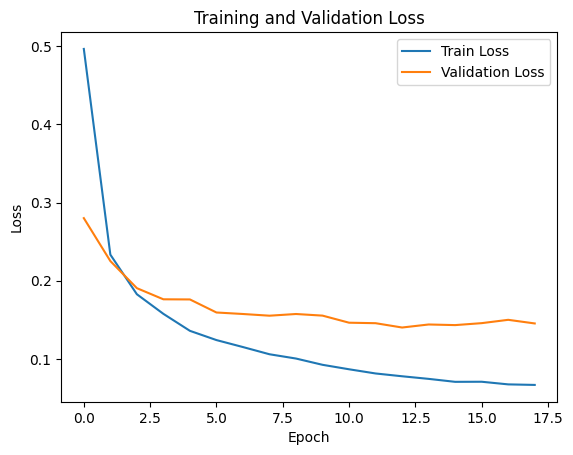

In [19]:
if train_losses is not None:
    plt.plot(train_losses, label='Train Loss')
if val_losses is not None:
    plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Evaluate on test set

In [20]:
out = net.forward(X_test)
preds = np.argmax(out, axis=1)
labels = np.argmax(y_test, axis=1)
accuracy = np.mean(preds == labels)
print(f'Test accuracy: {accuracy * 100:.2f}%')

Test accuracy: 96.20%


## Confusion Matrix

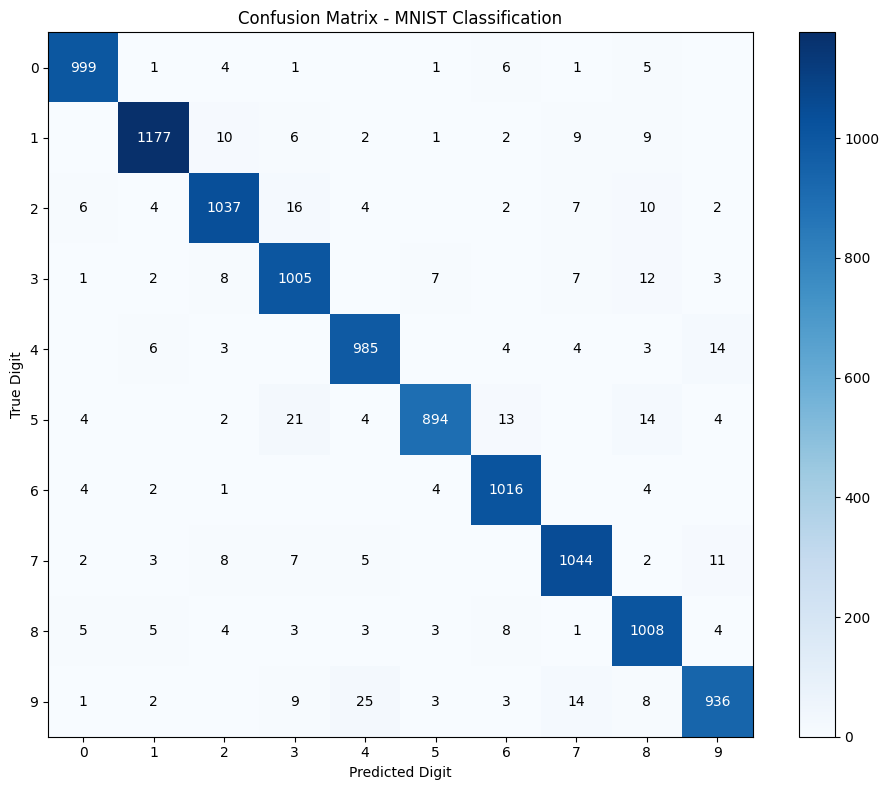

In [21]:
# Create confusion matrix
import matplotlib.pyplot as plt

def create_confusion_matrix(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for true, pred in zip(y_true, y_pred):
        cm[true, pred] += 1
    return cm

cm = create_confusion_matrix(labels, preds, 10)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix - MNIST Classification')
plt.colorbar()

# Add text annotations for non-zero values 
for i in range(10):
    for j in range(10):
        if cm[i, j] > 0:
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', 
                    fontsize=10, color='white' if cm[i, j] > cm.max()/2 else 'black')

plt.xlabel('Predicted Digit')
plt.ylabel('True Digit')
plt.xticks(range(10))
plt.yticks(range(10))
plt.tight_layout()
plt.show()



## Other statistics from testing

In [22]:
# Print per-class accuracy
print("\nPer-class Accuracy:")
print("Digit  Correct  Total  Accuracy")
print("-" * 32)
for i in range(10):
    correct = cm[i, i]
    total = np.sum(cm[i, :])
    acc = correct / total if total > 0 else 0
    print(f"  {i}      {correct:3d}    {total:3d}    {acc:.3f}")

# Show some misclassified examples
print(f"\nTotal test samples: {len(labels)}")
print(f"Correctly classified: {np.sum(preds == labels)}")
print(f"Misclassified: {np.sum(preds != labels)}")

# Find most common misclassifications
print("\nMost common misclassifications:")
misclass_counts = {}
for true, pred in zip(labels, preds):
    if true != pred:
        key = f"{true} → {pred}"
        misclass_counts[key] = misclass_counts.get(key, 0) + 1

# Sort and show top 5 misclassifications
sorted_misclass = sorted(misclass_counts.items(), key=lambda x: x[1], reverse=True)
for i, (misclass, count) in enumerate(sorted_misclass[:5]):
    print(f"{i+1}. {misclass}: {count} times")


Per-class Accuracy:
Digit  Correct  Total  Accuracy
--------------------------------
  0      999    1018    0.981
  1      1177    1216    0.968
  2      1037    1088    0.953
  3      1005    1045    0.962
  4      985    1019    0.967
  5      894    956    0.935
  6      1016    1031    0.985
  7      1044    1082    0.965
  8      1008    1044    0.966
  9      936    1001    0.935

Total test samples: 10500
Correctly classified: 10101
Misclassified: 399

Most common misclassifications:
1. 9 → 4: 25 times
2. 5 → 3: 21 times
3. 2 → 3: 16 times
4. 4 → 9: 14 times
5. 5 → 8: 14 times
